In [92]:
import av
import numpy as np
from numpy.random import randint
from time import sleep
from einops.layers.torch import Rearrange
from typing import List, Tuple
import torch
from torchvision.transforms import Compose

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
os.chdir('../')

from src.opts.opts import parser
from src.utils.reproducibility import make_reproducible
from src.models.model import VideoModel
from src.dataset.video_dataset import VideoDataset
from src.dataset.video_dataset import prepare_clips_data
from src.dataset.video_transforms import GroupMultiScaleCrop, Stack, ToTorchFormatTensor, GroupRandomHorizontalFlip
from src.dataset.frame_loader import load_av_frames_from_video
from src.dataset.temporal_sampling import temporal_sampling

In [10]:
args = parser.parse_args(args=[])
args.__dict__

{'holoassist_dir': '/Users/artemmerinov/data/holoassist/HoloAssist',
 'raw_annotation_file': '/Users/artemmerinov/data/holoassist/data-annotation-trainval-v1_1.json',
 'split_dir': '/Users/artemmerinov/data/holoassist/data-splits-v1_2',
 'fga_map_file': '/Users/artemmerinov/data/holoassist/fine_grained_actions_map.txt',
 'base_model': 'InceptionV3',
 'fusion_mode': None,
 'num_segments': 8,
 'num_classes': 1887,
 'resume': None,
 'start_epoch': 0,
 'pretrained': 'ImageNet',
 'num_epochs': 10,
 'lr': 0.01,
 'momentum': 0.9,
 'weight_decay': 0.0005,
 'clip_gradient': None,
 'batch_size': 16,
 'num_workers': 4,
 'prefetch_factor': 2,
 'debug': False,
 'fps': 10}

In [80]:
from collections import Counter, defaultdict
import json

In [ ]:
with open(args.raw_annotation_file) as f:
    raw_annt = json.load(f)

In [210]:
len(raw_annt)

1758

In [212]:
tr_list_path = os.path.join(args.split_dir, "train-v1_2.txt")
va_list_path = os.path.join(args.split_dir, "val-v1_2.txt")
te_list_path = os.path.join(args.split_dir, "test-v1_2.txt")

with open(tr_list_path, 'r') as file:
    tr_video_list = [line.strip() for line in file.readlines()]

with open(va_list_path, 'r') as file:
    va_video_list = [line.strip() for line in file.readlines()]

with open(te_list_path, 'r') as file:
    te_video_list = [line.strip() for line in file.readlines()]

print(len(tr_video_list), len(va_video_list), len(te_video_list))

1466 207 438


In [216]:
1466+207+438

2111

# FGA duration

In [249]:
fga_duration_list = []
fga_verb_list = []
fga_noun_list = []
fga_action_list = []

for video in raw_annt:
    events = video["events"]
    for event in events:
        if event["label"] == "Fine grained action":
            fga_duration_list.append(event['end'] - event['start'])
            fga_verb_list.append(event["attributes"]['Verb'])
            fga_noun_list.append(event["attributes"]['Noun'])
            fga_action_list.append(f"{event['attributes']['Verb']}-{event['attributes']['Noun']}")

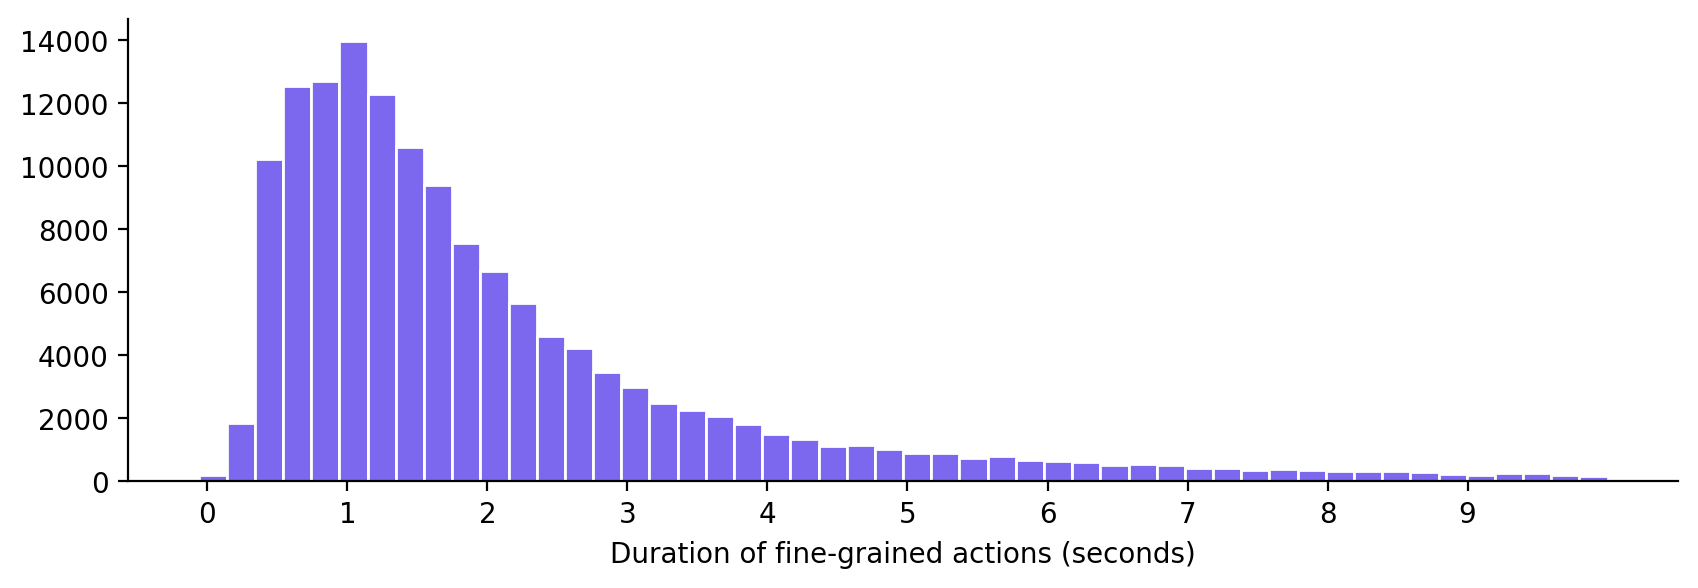

In [359]:
fga_duration_arr = np.array(fga_duration_list) 
fga_duration_arr = fga_duration_arr[fga_duration_arr < 10]

plt.figure(figsize=(10,3))
plt.hist(fga_duration_arr, bins=50, color='mediumslateblue', edgecolor='white');
plt.xticks(np.arange(10));
plt.xlabel("Duration of fine-grained actions (seconds)")

# Customize the plot to keep only the horizontal line (bottom spine)
ax = plt.gca()
# Hide all spines except for the bottom (x-axis) spine
for spine in ax.spines.values():
    spine.set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

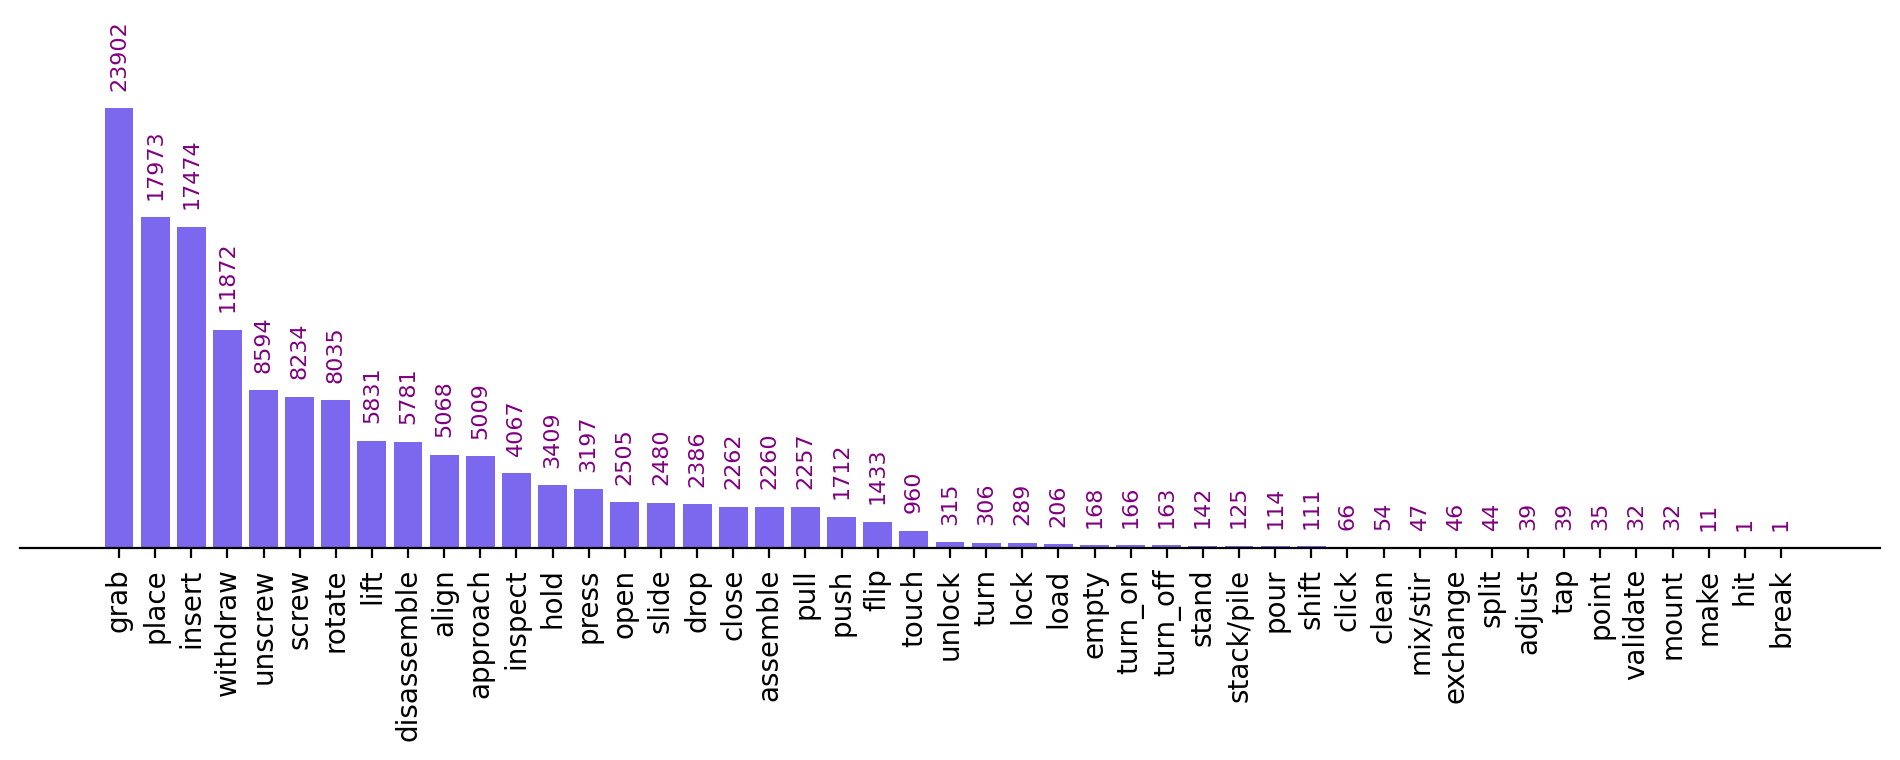

In [356]:
fga_verb_cntr = Counter(fga_verb_list).most_common()[:50]

labels = [name for name, cnt in fga_verb_cntr]
counts = [cnt for name, cnt in fga_verb_cntr]

plt.figure(figsize=(12,3))
bars = plt.bar(labels, counts, color='mediumslateblue') # plum

# Annotate each bar with its count value, rotating the text vertically
for bar, count in zip(bars, counts):
    plt.text(x=bar.get_x() + bar.get_width() / 2,
             y=bar.get_height() + 1000,
             s=count,                             
             ha='center',
             va='bottom',
             color='purple',
             fontsize=8,
             rotation=90)
    
# Customize the plot to remove vertical axis elements
ax = plt.gca()

# Hide the y-axis spine, ticks, and labels
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks([])
ax.yaxis.set_ticklabels([])

# Show only the bottom (x-axis) spine and ticks
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(rotation=90);

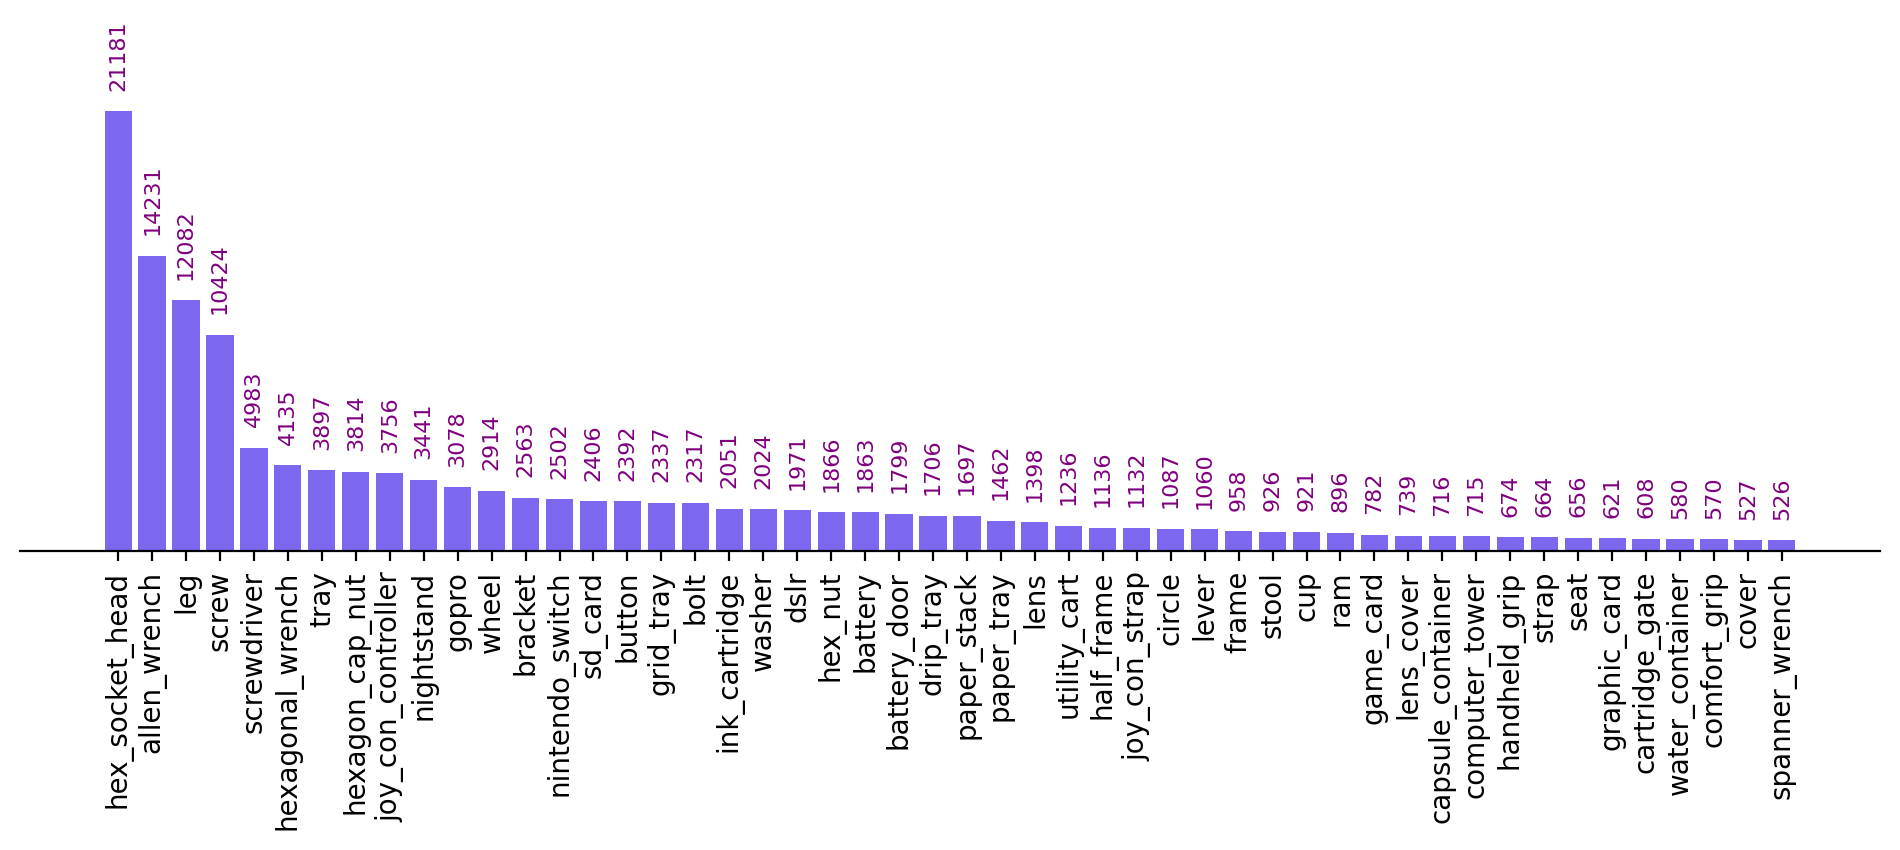

In [357]:
fga_noun_cntr = Counter(fga_noun_list).most_common()[:50]

labels = [name for name, cnt in fga_noun_cntr]
counts = [cnt for name, cnt in fga_noun_cntr]

plt.figure(figsize=(12,3))
bars = plt.bar(labels, counts, color='mediumslateblue') # plum

# Annotate each bar with its count value, rotating the text vertically
for bar, count in zip(bars, counts):
    plt.text(x=bar.get_x() + bar.get_width() / 2,
             y=bar.get_height() + 1000,
             s=count,                             
             ha='center',
             va='bottom',
             color='purple',
             fontsize=8,
             rotation=90)
    
# Customize the plot to remove vertical axis elements
ax = plt.gca()

# Hide the y-axis spine, ticks, and labels
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks([])
ax.yaxis.set_ticklabels([])

# Show only the bottom (x-axis) spine and ticks
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(rotation=90);

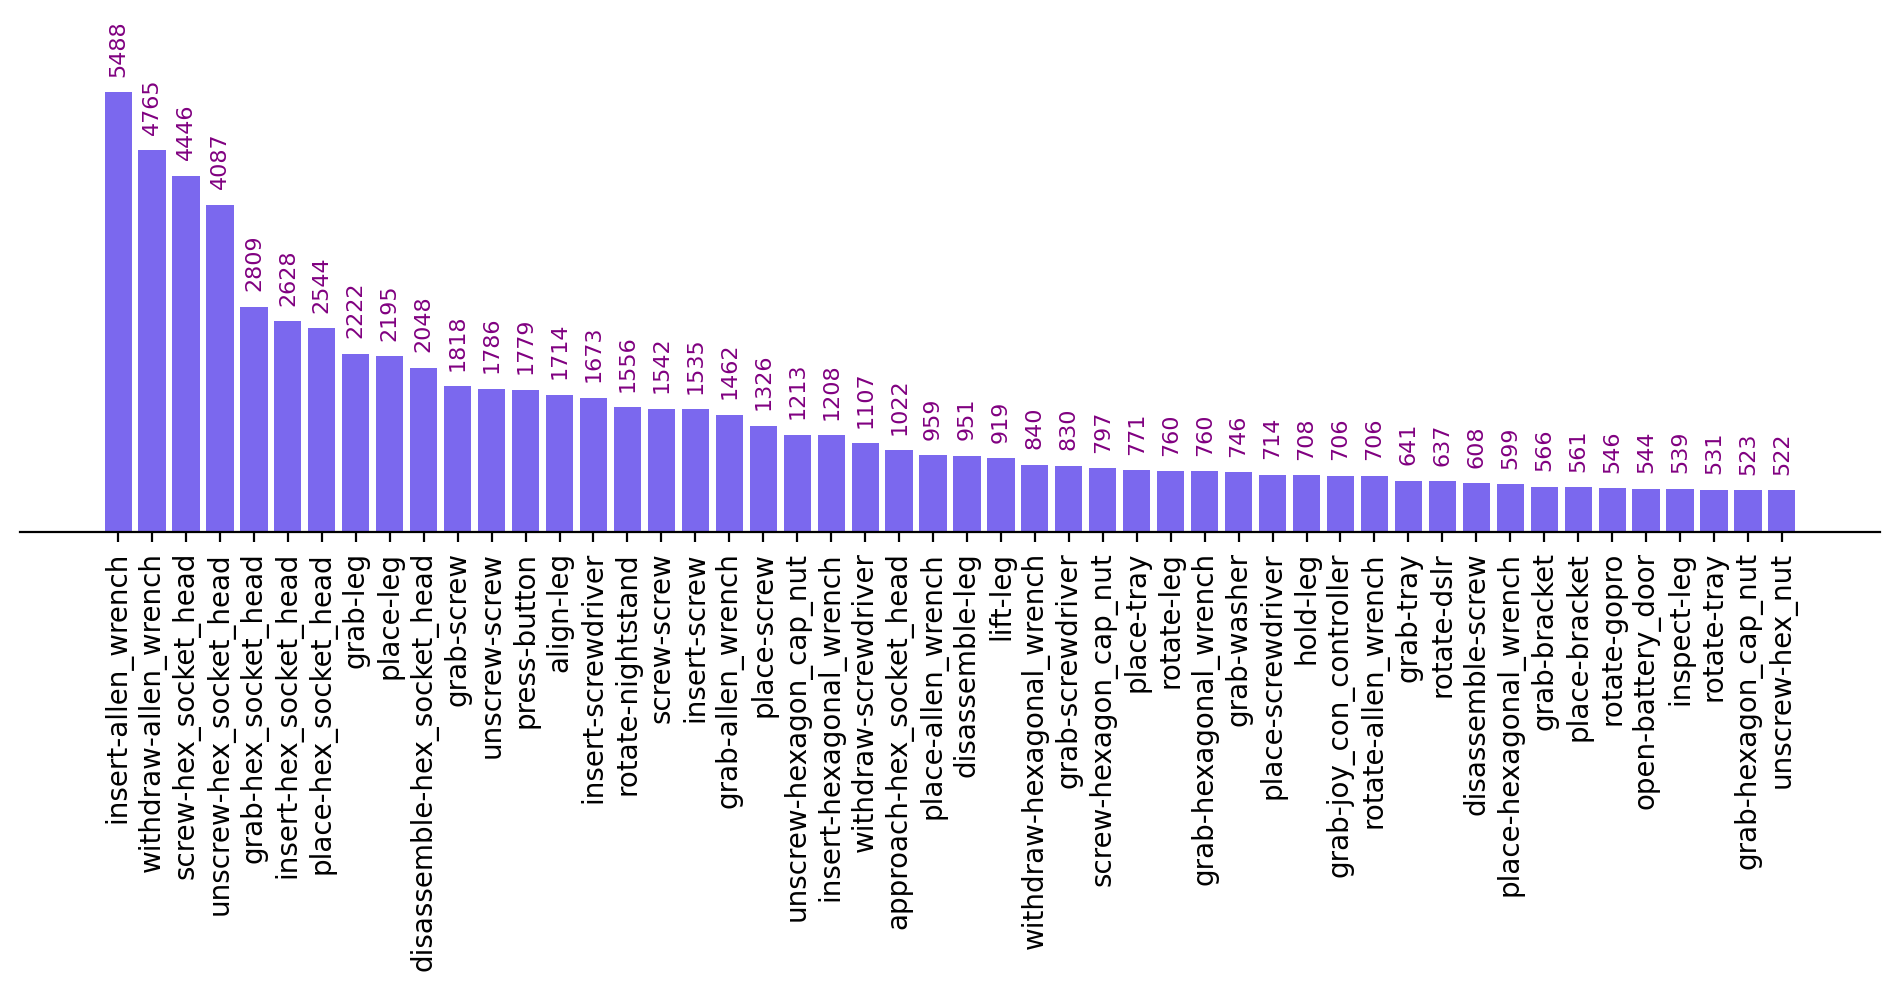

In [358]:
fga_action_cntr = Counter(fga_action_list).most_common()[:50]

labels = [name for name, cnt in fga_action_cntr]
counts = [cnt for name, cnt in fga_action_cntr]

plt.figure(figsize=(12,3))
bars = plt.bar(labels, counts, color='mediumslateblue') # plum

# Annotate each bar with its count value, rotating the text vertically
for bar, count in zip(bars, counts):
    plt.text(x=bar.get_x() + bar.get_width() / 2,
             y=bar.get_height() + 200,
             s=count,                             
             ha='center',
             va='bottom',
             color='purple',
             fontsize=8,
             rotation=90)
    
# Customize the plot to remove vertical axis elements
ax = plt.gca()

# Hide the y-axis spine, ticks, and labels
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks([])
ax.yaxis.set_ticklabels([])

# Show only the bottom (x-axis) spine and ticks
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(rotation=90);

# task type

In [199]:
task_type_list = []
tr_task_type_list = []
va_task_type_list = []

for video in raw_annt:
    task_type_list.append(video["taskType"])

    video_name = video['video_name']
    if video_name in tr_video_list:
        tr_task_type_list.append(video["taskType"])
    elif video_name in va_video_list:
        va_task_type_list.append(video["taskType"])
    
task_type_cntr = Counter(task_type_list).most_common()
tr_task_type_cntr = Counter(tr_task_type_list).most_common()
va_task_type_cntr = Counter(va_task_type_list).most_common()

len(task_type_cntr), len(tr_task_type_cntr), len(va_task_type_cntr)

(20, 20, 20)

In [215]:
len(tr_task_type_list) 

1466

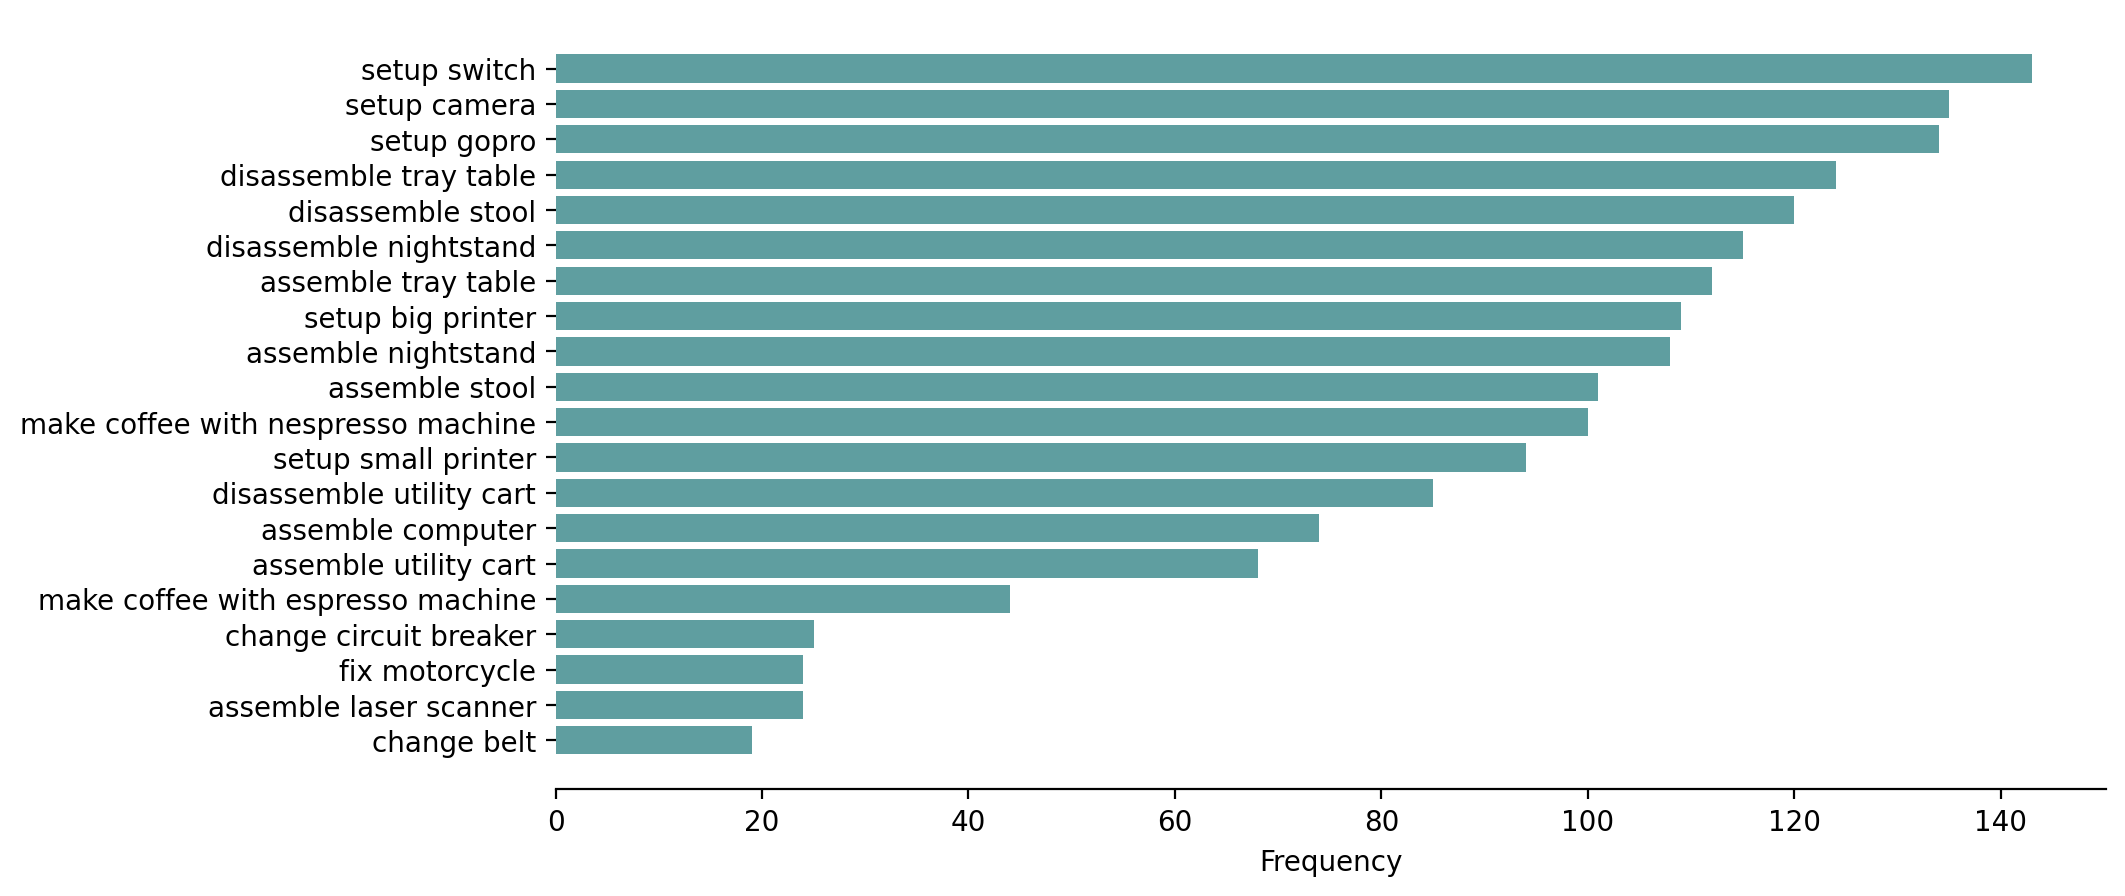

In [174]:
labels = [name for name, cnt in task_type_cntr]
counts = [cnt for name, cnt in task_type_cntr]

sorted_indices = np.argsort(counts)
sorted_labels = np.array(labels)[sorted_indices]
sorted_counts = np.array(counts)[sorted_indices]

plt.figure(figsize=(10,5))
plt.barh(sorted_labels, sorted_counts, color='cadetblue')

# Customize the plot to keep only the horizontal line (bottom spine)
ax = plt.gca()
# Hide all spines except for the bottom (x-axis) spine
for spine in ax.spines.values():
    spine.set_visible(False)
ax.spines['bottom'].set_visible(True)

plt.xlabel('Frequency');

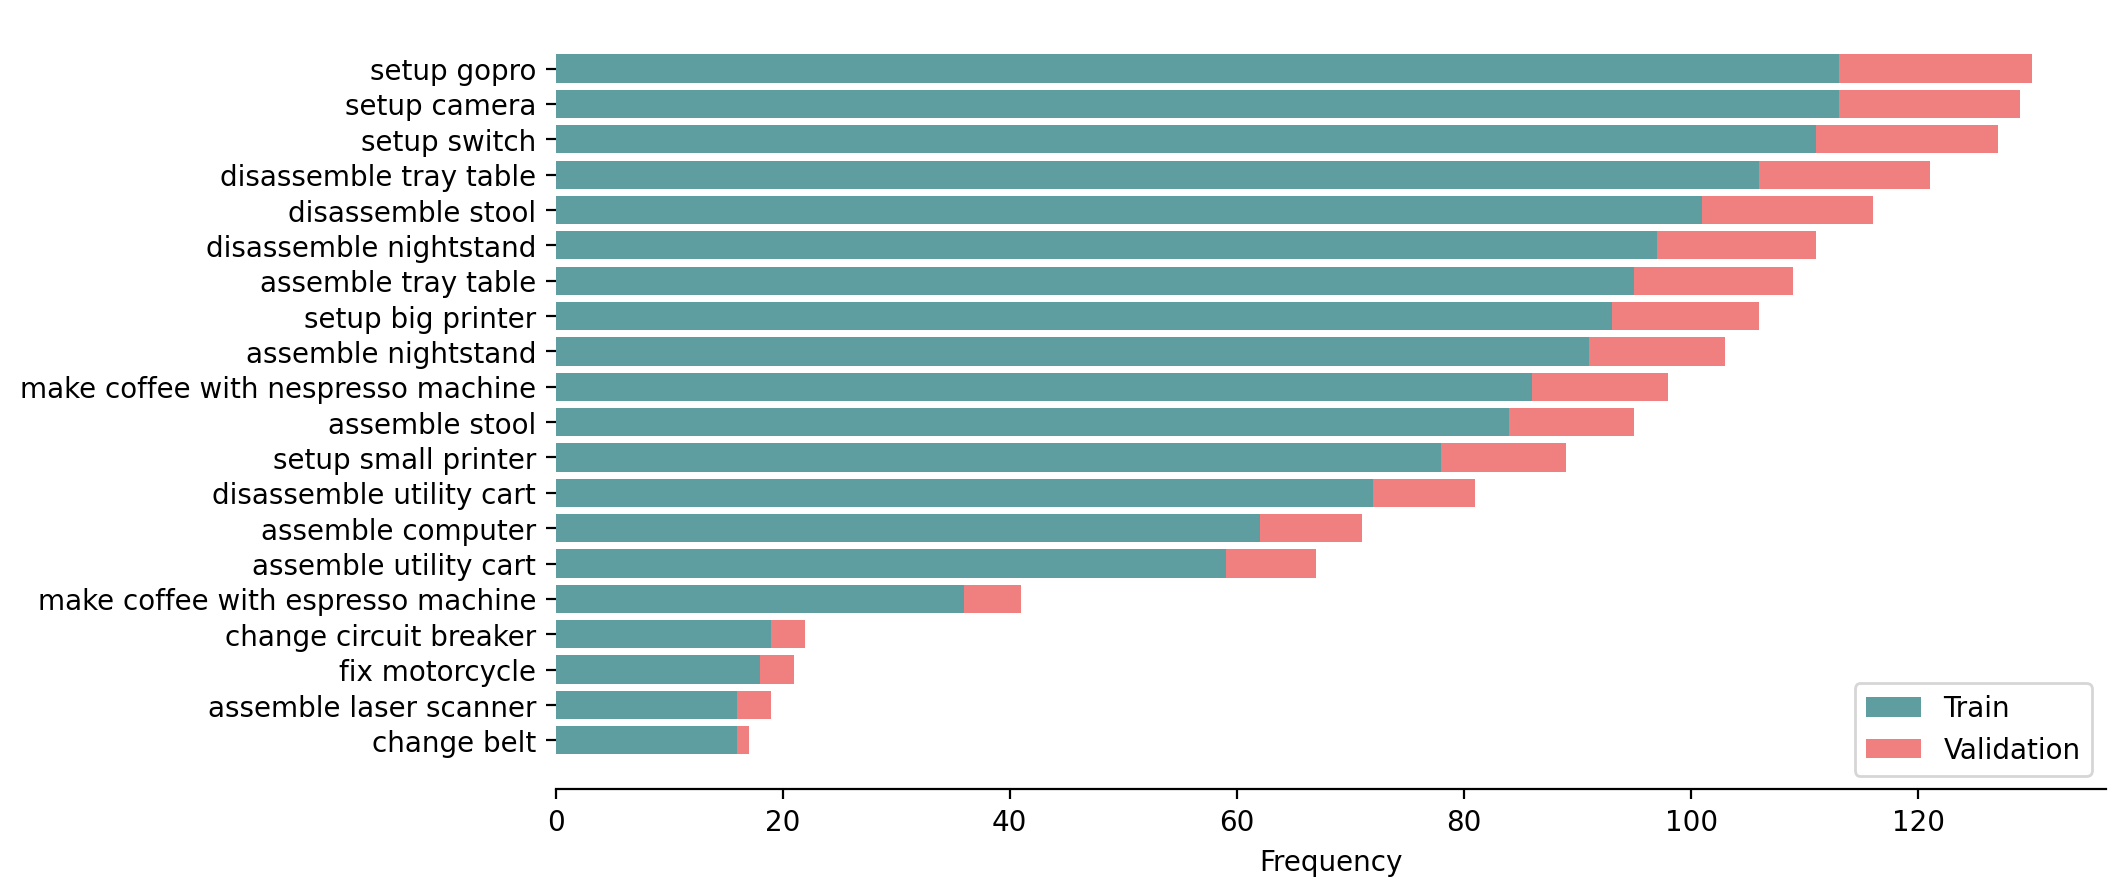

In [208]:
# Extract and sort data for training
train_labels = [name for name, cnt in tr_task_type_cntr]
train_counts = [cnt for name, cnt in tr_task_type_cntr]
sorted_train_indices = np.argsort(train_counts)
sorted_train_labels = np.array(train_labels)[sorted_train_indices]
sorted_train_counts = np.array(train_counts)[sorted_train_indices]

# Extract and sort data for validation (ensure same order as train)
val_counts = [cnt for name, cnt in va_task_type_cntr if name in sorted_train_labels]
sorted_val_counts = np.array(val_counts)[np.argsort(train_counts)]

# Create a stacked horizontal bar plot
plt.figure(figsize=(10,5))
bars1 = plt.barh(sorted_train_labels, sorted_train_counts, color='cadetblue', label='Train')
bars2 = plt.barh(sorted_train_labels, sorted_val_counts, left=sorted_train_counts, color='lightcoral', label='Validation')

# Customize the plot to keep only the horizontal line (bottom spine)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.spines['bottom'].set_visible(True)

# Add labels, title, and legend
plt.xlabel('Frequency')
plt.legend()

# Display the plot
plt.show()